<a href="https://colab.research.google.com/github/anilsrml/edu-performance-classifier/blob/main/edu_performance_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
# 1. ARFF dosyasını oku
data, meta = arff.loadarff("dataset.arff")

# 2. DataFrame'e dönüştür
df = pd.DataFrame(data)
catCols = [col for col in df.columns if df[col].dtype=="O"]
catCols[:5]

df[catCols]=df[catCols].apply(lambda x: x.str.decode('utf8'))
df

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,Excellent,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,Excellent,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,Excellent,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE
3,Excellent,male,General,WA,ONE,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,SCHOOL_TEACHER
4,Excellent,male,General,OA,TWO,SEBA,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE
...,...,...,...,...,...,...,...,...,...,...,...,...
661,Average,female,ST,WA,ONE,SEBA,AHSEC,ENGLISH,Good,Vg,OTHERS,HOUSE_WIFE
662,Average,male,ST,WA,THREE,SEBA,AHSEC,ENGLISH,Vg,Good,CULTIVATOR,HOUSE_WIFE
663,Average,male,ST,WA,TWO,SEBA,CBSE,ENGLISH,Good,Vg,OTHERS,SCHOOL_TEACHER
664,Average,male,ST,WA,THREE,SEBA,AHSEC,ENGLISH,Good,Good,SCHOOL_TEACHER,HOUSE_WIFE


In [ ]:
df.describe()

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
count,666,666,666,666,666,666,666,666,666,666,666,666
unique,4,2,4,3,6,3,3,3,4,4,8,9
top,Good,male,General,WA,TWO,SEBA,AHSEC,ENGLISH,Excellent,Excellent,OTHERS,HOUSE_WIFE
freq,210,355,329,449,368,396,368,536,511,398,277,442


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    object
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: object(12)
memory usage: 62.6+ KB


In [ ]:
df = df.drop(['medium', 'Class_ X_Percentage'], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Label encode for categorical columns
for col in ['Gender', 'Caste', 'coaching','Mother_occupation','Father_occupation']:
    df[col] = le.fit_transform(df[col])

# One-hot encoding uygulanacak sütunlar
one_hot_columns = ['Class_ten_education','twelve_education']

# One-hot encoding işlemi
df = pd.get_dummies(df, columns=one_hot_columns)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Mapping for 'time' column
df['time'] = df['time'].map({
    'ONE': 1, 'TWO': 2, 'THREE': 3,
    'FOUR': 4, 'FIVE': 5, 'SEVEN': 7
}).astype(int)

# Common mapping for percentage-like columns
percentage_map = {'Excellent': 4, 'Vg': 3, 'Good': 2, 'Average': 1}

for col in ['Class_XII_Percentage', 'Performance']:
    df[col] = df[col].map(percentage_map).astype(int)


In [ ]:
df

,Performance,Gender,Caste,coaching,time,Class_XII_Percentage,Father_occupation,Mother_occupation,Class_ten_education_CBSE,Class_ten_education_OTHERS,Class_ten_education_SEBA,twelve_education_AHSEC,twelve_education_CBSE,twelve_education_OTHERS
0,4,1,0,0,1,4,4,7,0,0,1,1,0,0
1,4,1,1,2,2,4,7,6,0,0,1,1,0,0
2,4,1,1,1,2,4,1,6,0,1,0,0,1,0
3,4,1,0,2,1,4,7,8,0,0,1,1,0,0
4,4,1,0,1,2,4,2,6,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1,0,3,2,1,3,6,6,0,0,1,1,0,0
662,1,1,3,2,3,2,3,6,0,0,1,1,0,0
663,1,1,3,2,2,3,6,8,0,0,1,0,1,0
664,1,1,3,2,3,2,7,6,0,0,1,1,0,0


In [ ]:
for c in df:
    print(f"{c} -> {df[c].unique()}")


Performance -> [4 3 2 1]
Gender -> [1 0]
Caste -> [0 1 2 3]
coaching -> [0 2 1]
time -> [1 2 3 4 5 7]
Class_XII_Percentage -> [4 3 2 1]
Father_occupation -> [4 7 1 2 6 0 5 3]
Mother_occupation -> [7 6 8 4 2 0 1 3 5]
Class_ten_education_CBSE -> [0 1]
Class_ten_education_OTHERS -> [0 1]
Class_ten_education_SEBA -> [1 0]
twelve_education_AHSEC -> [1 0]
twelve_education_CBSE -> [0 1]
twelve_education_OTHERS -> [0 1]


In [ ]:
def feature_engineering(df):
    """Yeni özellikler oluşturur (Feature Engineering)"""
    print("Yeni özellikler oluşturuluyor...")

    # 1. Eğitim süresi ile performans ilişkisi
    if 'time' in df.columns and 'Class_XII_Percentage' in df.columns:
        df['time_performance_ratio'] = df['time'] / (df['Class_XII_Percentage'] + 1)

    # 2. Aile eğitim seviyesi kombinasyonu
    if 'Father_occupation' in df.columns and 'Mother_occupation' in df.columns:
        df['parent_occupation_combined'] = df['Father_occupation'] * 10 + df['Mother_occupation']

    # 3. Eğitim kalitesi skoru (12. sınıf + coaching etkisi)
    if 'coaching' in df.columns and 'Class_XII_Percentage' in df.columns:
        df['education_quality_score'] = df['Class_XII_Percentage'] + (df['coaching'] * 0.5)

    # 4. Zaman kategorisi (kısa, orta, uzun süreli)
    if 'time' in df.columns:
        df['time_category'] = pd.cut(df['time'], bins=[0, 2, 4, 7], labels=[0, 1, 2])
        df['time_category'] = df['time_category'].astype(int)

    return df

In [ ]:
df = feature_engineering(df)

Yeni özellikler oluşturuluyor...


In [ ]:
def clean_outliers(df, method='iqr_robust'):
    import numpy as np
    import pandas as pd

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    if method == 'iqr_robust':
        condition = pd.Series([True] * len(df))

        for col in numeric_cols:
            Q1 = df[col].quantile(0.15)
            Q3 = df[col].quantile(0.85)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.0 * IQR
            upper_bound = Q3 + 1.0 * IQR

            col_condition = (df[col] >= lower_bound) & (df[col] <= upper_bound)
            condition = condition & col_condition

        df_clean = df[condition]

    elif method == 'zscore':
        from scipy import stats
        condition = pd.Series([True] * len(df))

        for col in numeric_cols:
            z_scores = np.abs(stats.zscore(df[col]))
            condition = condition & (z_scores < 2.5)

        df_clean = df[condition]

    else:
        raise ValueError("Method must be 'iqr_robust' or 'zscore'.")

    return df_clean


df_cleaned = clean_outliers(df, method='iqr_robust')


In [ ]:
def scale_features(X_train, X_test, method='standard'):
    """Özellikleri ölçeklendirir"""
    print(f"Özellik ölçeklendirmesi yapılıyor ({method})...")

    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame formatına geri dönüştür
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_train_scaled, X_test_scaled

In [ ]:
def feature_selection(X, y, method='rfe', n_features=15):
    """Özellik seçimi yapar"""
    print(f"Özellik seçimi yapılıyor ({method})...")
    print(f"Özellik seçimi öncesi: {X.shape[1]} özellik")

    if method == 'selectkbest':
        # En iyi K özelliği seç
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_selected_array = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()]
        X_selected = pd.DataFrame(X_selected_array, columns=selected_features, index=X.index)

    elif method == 'rfe':
        # Recursive Feature Elimination
        rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
        selector = RFE(estimator=rf_temp, n_features_to_select=n_features)
        X_selected_array = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()]
        X_selected = pd.DataFrame(X_selected_array, columns=selected_features, index=X.index)

    elif method == 'importance':
        # Random Forest feature importance
        rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_temp.fit(X, y)

        # En önemli özellikleri seç
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_temp.feature_importances_
        }).sort_values('importance', ascending=False)

        selected_features = importance_df.head(n_features)['feature'].values
        X_selected = X[selected_features]

    print(f"Seçilen özellikler ({len(selected_features)}):")
    print(list(selected_features)[:10], "..." if len(selected_features) > 10 else "")

    return X_selected, selected_features

In [ ]:
def prepare_data(df, use_feature_selection=True, scaling_method='standard'):
    """Veriyi train-test olarak ayırır ve SMOTE uygular"""
    print("Veri ayrılıyor ve dengeleniyor...")

    X = df.drop('Performance', axis=1)
    y = df['Performance']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Özellik seçimi (opsiyonel)
    if use_feature_selection:
        X_train_selected, selected_features = feature_selection(X_train, y_train, method='rfe', n_features=12)
        X_test_selected = X_test[selected_features]
        X_train, X_test = X_train_selected, X_test_selected

    # Özellik ölçeklendirmesi
    X_train, X_test = scale_features(X_train, X_test, method=scaling_method)

    print("SMOTE öncesi sınıf dağılımı:", dict(Counter(y_train)))

    # SMOTE ile sınıf dengelemesi
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # SMOTE sonrası DataFrame'e dönüştür ve index'leri sıfırla
    if hasattr(X_train, 'columns'):
        X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

    print("SMOTE sonrası sınıf dağılımı:", dict(Counter(y_train_res)))

    return X_train_res, X_test, y_train_res, y_test


# Fonksiyonu çağırırken aynı girintide olduğundan emin olun:
X_train, X_test, y_train, y_test = prepare_data(
    df,
    use_feature_selection=True,
    scaling_method='standard'
)


Veri ayrılıyor ve dengeleniyor...
Özellik seçimi yapılıyor (rfe)...
Özellik seçimi öncesi: 17 özellik
Seçilen özellikler (12):
['Gender', 'Caste', 'coaching', 'time', 'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation', 'Class_ten_education_SEBA', 'twelve_education_CBSE', 'time_performance_ratio'] ...
Özellik ölçeklendirmesi yapılıyor (standard)...
SMOTE öncesi sınıf dağılımı: {4: 81, 1: 125, 2: 168, 3: 158}
SMOTE sonrası sınıf dağılımı: {4: 168, 1: 168, 2: 168, 3: 168}


In [ ]:
df

,Performance,Gender,Caste,coaching,time,Class_XII_Percentage,Father_occupation,Mother_occupation,Class_ten_education_CBSE,Class_ten_education_OTHERS,Class_ten_education_SEBA,twelve_education_AHSEC,twelve_education_CBSE,twelve_education_OTHERS,time_performance_ratio,parent_occupation_combined,education_quality_score,time_category
0,4,1,0,0,1,4,4,7,0,0,1,1,0,0,0.200000,47,4.0,0
1,4,1,1,2,2,4,7,6,0,0,1,1,0,0,0.400000,76,5.0,0
2,4,1,1,1,2,4,1,6,0,1,0,0,1,0,0.400000,16,4.5,0
3,4,1,0,2,1,4,7,8,0,0,1,1,0,0,0.200000,78,5.0,0
4,4,1,0,1,2,4,2,6,0,0,1,0,1,0,0.400000,26,4.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1,0,3,2,1,3,6,6,0,0,1,1,0,0,0.250000,66,4.0,0
662,1,1,3,2,3,2,3,6,0,0,1,1,0,0,1.000000,36,3.0,1
663,1,1,3,2,2,3,6,8,0,0,1,0,1,0,0.500000,68,4.0,0
664,1,1,3,2,3,2,7,6,0,0,1,1,0,0,1.000000,76,3.0,1


In [ ]:
def enhanced_train_model(X_train, y_train):
    """Gelişmiş Random Forest modelini eğitir ve en iyi parametreleri bulur"""
    print("Gelişmiş model eğitimi başlıyor...")

    rf = RandomForestClassifier(random_state=42)

    # Daha kapsamlı parametre grid'i

    param_grid = {

        'n_estimators': [100],
        'max_depth': [12],
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'class_weight': ['balanced']
    }

    # Stratified K-Fold cross validation
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy',
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    print("En iyi parametreler:", grid_search.best_params_)
    print("En iyi CV skoru:", round(grid_search.best_score_, 4))
    print("CV standart sapması:", round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4))

    return grid_search.best_estimator_

In [ ]:
best_model = enhanced_train_model(X_train, y_train)

Gelişmiş model eğitimi başlıyor...
Fitting 7 folds for each of 1 candidates, totalling 7 fits
En iyi parametreler: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
En iyi CV skoru: 0.5952
CV standart sapması: 0.0171


In [ ]:
def evaluate_model(model, X_test, y_test):
    """Modeli değerlendirir ve sonuçları yazdırır"""
    print("\nModel değerlendirmesi:")

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Doğruluk (Accuracy): {accuracy:.4f}")

    # Sınıflandırma raporundan sensitivity (recall), specificity ve f1-score elde etme
    report = classification_report(y_test, y_pred, output_dict=True)

    # Mevcut sınıfları al
    unique_classes = sorted(list(set(y_test) | set(y_pred)))
    print(f"Mevcut sınıflar: {unique_classes}")

    # Macro average değerleri kullan (tüm sınıflar için ortalama)
    sensitivity = report['macro avg']['recall']
    print(f"Duyarlılık (Sensitivity - Macro Avg): {sensitivity:.4f}")

    # Weighted average kullan
    specificity = report['weighted avg']['precision']
    print(f"Özgüllük (Specificity - Weighted Avg): {specificity:.4f}")

    # F-measure (F1-score) - macro average
    f_measure = report['macro avg']['f1-score']
    print(f"F-Ölçüsü (F-measure - Macro Avg): {f_measure:.4f}")
    return accuracy

In [ ]:
accuracy = evaluate_model(best_model, X_test, y_test)


Model değerlendirmesi:
Doğruluk (Accuracy): 0.5224
Mevcut sınıflar: [1, 2, 3, 4]
Duyarlılık (Sensitivity - Macro Avg): 0.5193
Özgüllük (Specificity - Weighted Avg): 0.5256
F-Ölçüsü (F-measure - Macro Avg): 0.5141


<Figure size 1200x600 with 0 Axes>

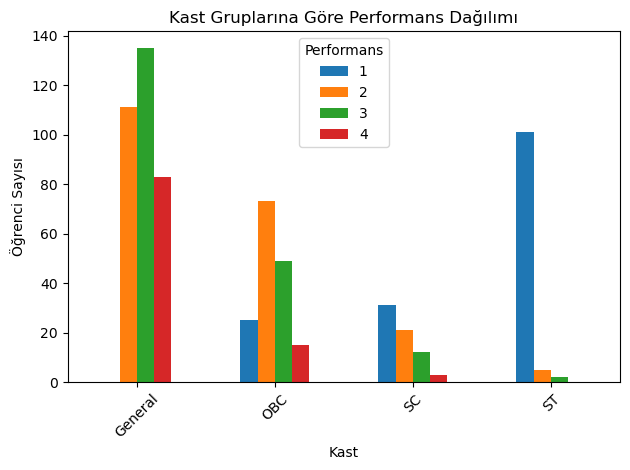

In [ ]:
caste_mapping = {
    0: 'General',
    1: 'OBC',
    2: 'SC',
    3: 'ST'
}

df['Caste'] = df['Caste'].map(caste_mapping)

caste_perf = pd.crosstab(df['Caste'], df['Performance'])

# Matplotlib ile çubuk grafik oluştur
plt.figure(figsize=(12, 6))
caste_perf.plot(kind='bar')
plt.title('Kast Gruplarına Göre Performans Dağılımı')
plt.xlabel('Kast')
plt.ylabel('Öğrenci Sayısı')
plt.legend(title='Performans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Karmaşıklık matrisi görselleştiriliyor...


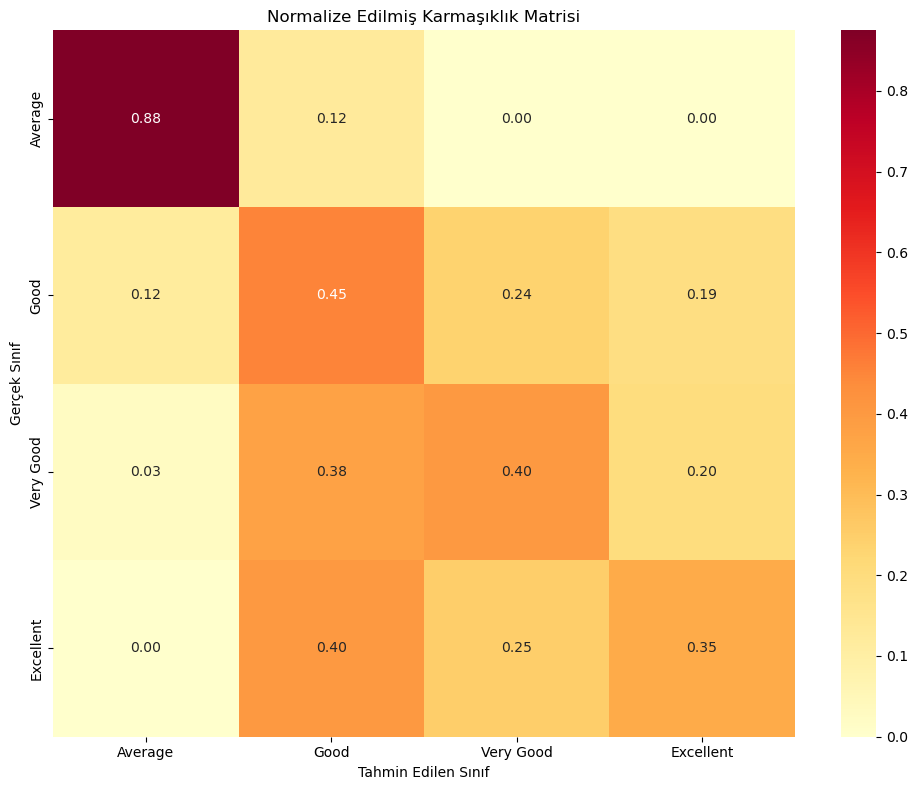

In [ ]:
# Karmaşıklık matrisini görselleştirir
print("Karmaşıklık matrisi görselleştiriliyor...")

# Karmaşıklık matrisini hesapla
cm = confusion_matrix(y_true, y_pred)

# Normalize edilmiş karmaşıklık matrisi
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Tek bir figür oluştur
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=['Average', 'Good', 'Very Good', 'Excellent'],
            yticklabels=['Average', 'Good', 'Very Good', 'Excellent'])
plt.title('Normalize Edilmiş Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')

plt.tight_layout()
plt.show()



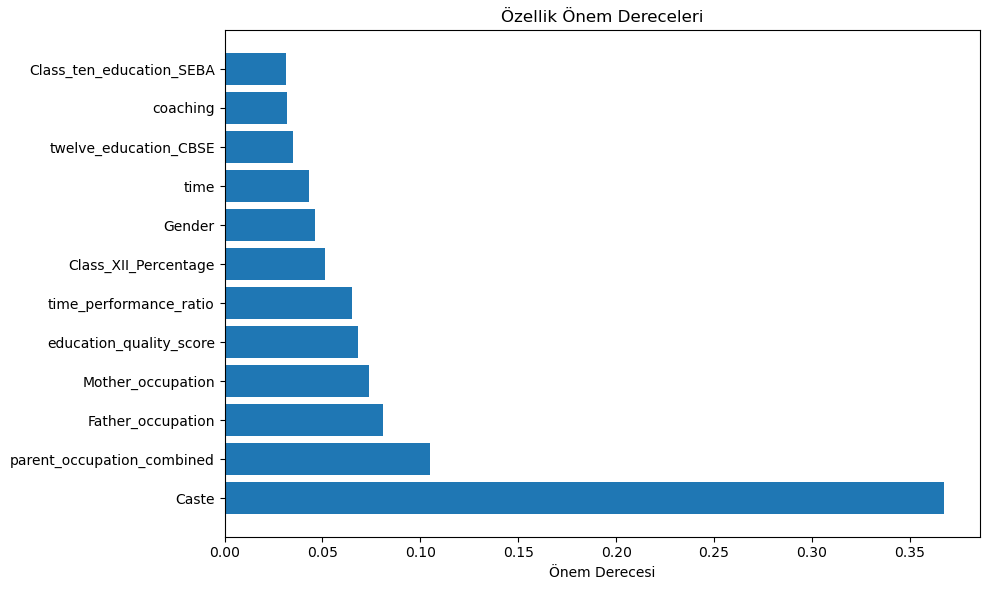

In [ ]:
# Özellik isimlerini tanımla
feature_names = X_train.columns.tolist()

# Özellik önemlerini al
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Matplotlib ile çubuk grafik oluştur
plt.figure(figsize=(10, 6))
plt.title('Özellik Önem Dereceleri')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Önem Derecesi')
plt.tight_layout()
plt.show()
